# kNN with Annoy + **Selective-Exactness kNN (SE-kNN)**

**Contribution:** uncertainty-aware hybrid kNN. First query a fast approximate kNN (Annoy). If the nearest-neighbor **distance margin** is small (low confidence), **fallback** to an exact kNN for that test point only.

This introduces a *tunable accuracy–latency trade-off* via a threshold \(\tau\) and adds **adaptive computation** to the original methodology.

## Environment setup

In [17]:
# This ensures all deps are present.
%pip -q install annoy scikit-learn pandas numpy matplotlib

## 1. Data: upload

Expected filenames:
- `letter-recognition.csv`
- `shuttle.csv`
- `CC_default.csv`
- `AthleteSelection.csv`

In [18]:
import os, pandas as pd, numpy as np

DATA_DIR = "/content"

FILENAMES = {
    "letter": "letter-recognition.csv",
    "shuttle": "shuttle.csv",
    "cc_default": "CC_default.csv",
    "athlete": "AthleteSelection.csv",
}

print("Looking for files in:", DATA_DIR)
for key, fn in FILENAMES.items():
    p = os.path.join(DATA_DIR, fn)
    print(f"{fn} → {'FOUND' if os.path.exists(p) else 'missing'}")

Looking for files in: /content
letter-recognition.csv → FOUND
shuttle.csv → FOUND
CC_default.csv → FOUND
AthleteSelection.csv → FOUND


## 2. Dataset loaders (robust parsing)

In [19]:
from typing import Tuple

def load_letter_recognition(path: str) -> Tuple[np.ndarray, np.ndarray, str]:
    # UCI Letter: first col is label (A..Z), remaining are numeric features
    df = pd.read_csv(path, header=None)
    if df.shape[1] < 2:
        raise ValueError("letter-recognition.csv has unexpected format.")
    X = df.iloc[:, 1:].values.astype(float)
    y = df.iloc[:, 0].astype(str).values
    return X, y, "letter-recognition"

def load_shuttle(path: str) -> Tuple[np.ndarray, np.ndarray, str]:
    df = pd.read_csv(path, header=None)
    X = df.iloc[:, :-1].values.astype(float)
    y = df.iloc[:, -1].astype(str).values
    return X, y, "shuttle"

def load_cc_default(path: str) -> Tuple[np.ndarray, np.ndarray, str]:
    df = pd.read_csv(path)
    # try common target names; otherwise assume last column
    candidates = [c for c in df.columns if c.lower() in [
        "default", "default.payment.next.month", "y", "label", "defaulted"
    ]]
    target = candidates[0] if candidates else df.columns[-1]
    y = df[target].astype(str).values
    X = df.drop(columns=[target]).copy()
    for c in X.columns:
        if X[c].dtype == "object":
            X[c] = pd.factorize(X[c])[0]
    return X.values.astype(float), y, f"CC_default[{target}]"

def load_athlete_selection(path: str) -> Tuple[np.ndarray, np.ndarray, str]:
    df = pd.read_csv(path)
    y = df.iloc[:, -1].astype(str).values
    X = df.iloc[:, :-1].copy()
    for c in X.columns:
        if X[c].dtype == "object":
            X[c] = pd.factorize(X[c])[0]
    return X.values.astype(float), y, "AthleteSelection"

LOADERS = []
p = os.path.join(DATA_DIR, FILENAMES["letter"])
if os.path.exists(p): LOADERS.append(lambda p=p: load_letter_recognition(p))
p = os.path.join(DATA_DIR, FILENAMES["shuttle"])
if os.path.exists(p): LOADERS.append(lambda p=p: load_shuttle(p))
p = os.path.join(DATA_DIR, FILENAMES["cc_default"])
if os.path.exists(p): LOADERS.append(lambda p=p: load_cc_default(p))
p = os.path.join(DATA_DIR, FILENAMES["athlete"])
if os.path.exists(p): LOADERS.append(lambda p=p: load_athlete_selection(p))

if not LOADERS:
    print("No expected datasets found yet. Upload, then re-run the previous cells.")
else:
    print(f"Datasets available: {len(LOADERS)}")

Datasets available: 4


## 3. SE-kNN contribution (hybrid Annoy → Exact fallback when uncertain)

In [20]:
from collections import Counter
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score
from annoy import AnnoyIndex
import time

class SelectiveExactKNN:
    def __init__(self, annoy_index, y_train, exact_knn, k=5, tau=1.2, search_k=-1):
        self.annoy = annoy_index
        self.y_train = np.asarray(y_train)
        self.exact = exact_knn
        self.k = k
        self.tau = tau
        self.search_k = search_k

    @staticmethod
    def margin(distances):
        if len(distances) < 2: return float("inf")
        d1, d2 = distances[0], distances[1]
        if d1 < 0: return float("inf")
        return d2 / (d1 + 1e-9)

    def predict(self, X):
        preds = np.empty(len(X), dtype=int)
        used_fallback = np.zeros(len(X), dtype=bool)
        for i, v in enumerate(X):
            idxs, dists = self.annoy.get_nns_by_vector(v.tolist(), self.k, search_k=self.search_k, include_distances=True)
            m = self.margin(dists)
            if (m < self.tau) or (len(idxs) == 0):
                preds[i] = int(self.exact.predict([v])[0]); used_fallback[i] = True
            else:
                preds[i] = Counter(self.y_train[idxs]).most_common(1)[0][0]; used_fallback[i] = False
        return preds, used_fallback

## 4. Training & benchmarking utilities

In [21]:
def prepare_split(X, y, test_size=0.25, random_state=42, scale=True):
    le = LabelEncoder()
    y_enc = le.fit_transform(y)
    X_tr, X_te, y_tr, y_te = train_test_split(
        X, y_enc, test_size=test_size, random_state=random_state,
        stratify=y_enc if len(np.unique(y_enc))>1 else None
    )
    if scale:
        sc = StandardScaler()
        X_tr = sc.fit_transform(X_tr); X_te = sc.transform(X_te)
    return X_tr, X_te, y_tr, y_te

def build_annoy(X_train, n_trees=50, metric="euclidean"):
    f = X_train.shape[1]
    ann = AnnoyIndex(f, metric)
    for i, v in enumerate(X_train):
        ann.add_item(i, v.tolist())
    t0 = time.time(); ann.build(n_trees); build_time = time.time()-t0
    return ann, build_time

def run_once(X, y, name, k=5, taus=(1.1,1.2,1.5), n_trees=50, search_k=-1):
    from pandas import DataFrame
    import time, numpy as np
    from collections import Counter
    from sklearn.preprocessing import StandardScaler, LabelEncoder
    from sklearn.model_selection import train_test_split
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.metrics import accuracy_score, f1_score
    from annoy import AnnoyIndex

    # split & scale
    le = LabelEncoder()
    y_enc = le.fit_transform(y)
    X_tr, X_te, y_tr, y_te = train_test_split(
        X, y_enc, test_size=0.25, random_state=42,
        stratify=y_enc if len(np.unique(y_enc))>1 else None
    )
    sc = StandardScaler()
    X_tr = sc.fit_transform(X_tr); X_te = sc.transform(X_te)

    # exact baseline
    knn = KNeighborsClassifier(n_neighbors=k, algorithm="auto")
    t0=time.time(); knn.fit(X_tr, y_tr); fit_t=time.time()-t0
    t0=time.time(); yhat = knn.predict(X_te); inf_t=(time.time()-t0)/len(X_te)
    rows=[{
        "dataset":name,"method":"Exact kNN","k":k,"tau":None,"param":None,
        "build_time_s":fit_t,"avg_infer_s":inf_t,
        "accuracy":accuracy_score(y_te,yhat),
        "macro_f1":f1_score(y_te,yhat,average="macro"),
        "fallback_rate":None
    }]

    # Annoy index
    f = X_tr.shape[1]
    ann = AnnoyIndex(f, "euclidean")
    for i, v in enumerate(X_tr): ann.add_item(i, v.tolist())
    t0=time.time(); ann.build(n_trees); build_t=time.time()-t0

    # Annoy-only prediction (no distances returned → no unpacking)
    preds=[]; t0=time.time()
    for v in X_te:
        idxs = ann.get_nns_by_vector(v.tolist(), k, search_k=search_k, include_distances=False)
        if len(idxs)==0:
            preds.append(knn.predict([v])[0])
        else:
            preds.append(Counter(y_tr[idxs]).most_common(1)[0][0])
    ann_time=(time.time()-t0)/len(X_te)
    rows.append({
        "dataset":name,"method":"Annoy-only","k":k,"tau":None,
        "param":f"n_trees={n_trees}, search_k={search_k}",
        "build_time_s":build_t,"avg_infer_s":ann_time,
        "accuracy":accuracy_score(y_te, preds),
        "macro_f1":f1_score(y_te, preds, average="macro"),
        "fallback_rate":None
    })

    # SE-kNN with tau sweep (keeps include_distances=True, so unpacking is fine)
    class SelectiveExactKNN:
        def __init__(self, annoy_index, y_train, exact_knn, k=5, tau=1.2, search_k=-1):
            self.annoy = annoy_index; self.y_train = np.asarray(y_train)
            self.exact = exact_knn; self.k = k; self.tau = tau; self.search_k = search_k
        @staticmethod
        def margin(dists):
            if len(dists)<2: return float("inf")
            d1, d2 = dists[0], dists[1]
            if d1 < 0: return float("inf")
            return d2/(d1+1e-9)
        def predict(self, X):
            used = np.zeros(len(X), dtype=bool); out = np.empty(len(X), dtype=int)
            for i, v in enumerate(X):
                idxs, dists = self.annoy.get_nns_by_vector(v.tolist(), self.k, search_k=self.search_k, include_distances=True)
                m = self.margin(dists)
                if (m < self.tau) or (len(idxs)==0):
                    out[i] = int(self.exact.predict([v])[0]); used[i] = True
                else:
                    out[i] = Counter(self.y_train[idxs]).most_common(1)[0][0]; used[i] = False
            return out, used

    for tau in taus:
        se = SelectiveExactKNN(ann, y_tr, knn, k=k, tau=tau, search_k=search_k)
        t0=time.time(); y_se, used = se.predict(X_te); se_time=(time.time()-t0)/len(X_te)
        rows.append({
            "dataset":name,"method":"SE-kNN (Annoy→Exact)","k":k,"tau":tau,
            "param":f"n_trees={n_trees}, search_k={search_k}",
            "build_time_s":build_t,"avg_infer_s":se_time,
            "accuracy":accuracy_score(y_te, y_se),
            "macro_f1":f1_score(y_te, y_se, average="macro"),
            "fallback_rate":float(used.mean())
        })

    return DataFrame(rows)

## 5. Run benchmarks

In [22]:
import pandas as pd

PARAMS = {
    "k": 5,
    "taus": [1.05, 1.1, 1.2, 1.5],
    "n_trees": 50,
    "search_k": -1,  # -1 lets Annoy decide an internal default
}

all_results = []
for loader in LOADERS:
    X, y, name = loader()
    # Skip datasets whose smallest class has < 2 samples
    y_enc_check = LabelEncoder().fit_transform(y)
    if np.bincount(y_enc_check).min() < 2:
        print(f"[SKIP] {name}: min class count < 2")
        continue
    df = run_once(X, y, name, k=PARAMS["k"], taus=PARAMS["taus"],
                  n_trees=PARAMS["n_trees"], search_k=PARAMS["search_k"])
    all_results.append(df)

[SKIP] shuttle: min class count < 2


## 6. Accuracy–latency trade-off plots

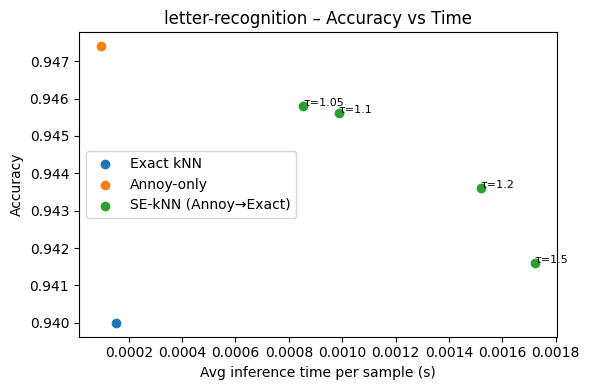

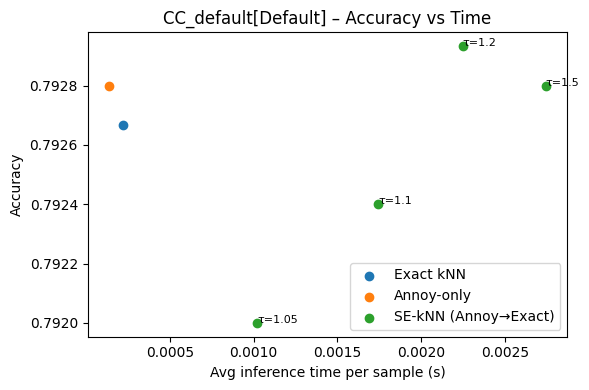

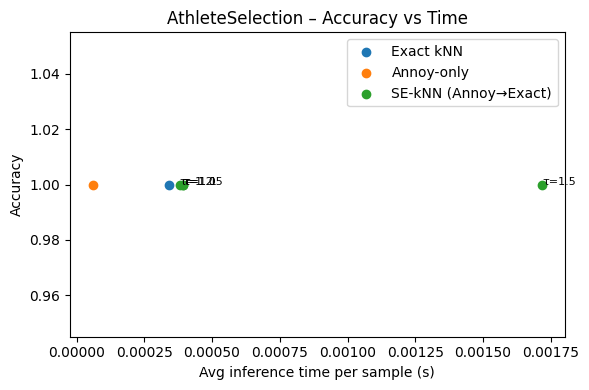

In [23]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Try to get results from memory; otherwise load from CSV; otherwise recompute.
if 'results' not in globals() or results is None or getattr(results, 'empty', True):
    DATA_DIR = globals().get('DATA_DIR', '/content')
    csv_path = os.path.join(DATA_DIR, 'seknn_results.csv')
    if os.path.exists(csv_path):
        results = pd.read_csv(csv_path)
        print(f"[INFO] Loaded results from {csv_path}")
    else:
        print("[INFO] results not found in memory or on disk. Trying to recompute…")
        if 'LOADERS' in globals() and 'run_once' in globals():
            PARAMS = globals().get('PARAMS', {"k":5, "taus":[1.05,1.1,1.2,1.5], "n_trees":50, "search_k":-1})
            all_results = []
            for loader in LOADERS:
                try:
                    X, y, name = loader()
                    df = run_once(X, y, name,
                                  k=PARAMS["k"],
                                  taus=PARAMS["taus"],
                                  n_trees=PARAMS["n_trees"],
                                  search_k=PARAMS["search_k"])
                    all_results.append(df)
                except Exception as e:
                    print(f"[WARN] Skipping {loader.__name__ if hasattr(loader,'__name__') else name}: {e}")
            results = pd.concat(all_results, ignore_index=True) if all_results else pd.DataFrame()
            if not results.empty:
                results.to_csv(csv_path, index=False)
                print(f"[INFO] Saved results to {csv_path}")
        else:
            raise RuntimeError("No results available. Re-run the benchmark cell first.")

# Ensure numeric types for plotting
for col in ['avg_infer_s', 'accuracy', 'tau']:
    if col in results.columns:
        results[col] = pd.to_numeric(results[col], errors='coerce')

if results.empty:
    raise RuntimeError("Results dataframe is empty. Verify that datasets loaded and benchmarks ran successfully.")

# Plot: Accuracy vs Avg inference time, annotated with τ where available
for ds in results["dataset"].dropna().unique():
    sub = results[results["dataset"] == ds].copy()
    if sub.empty:
        continue

    plt.figure(figsize=(6, 4))
    for m in sub["method"].dropna().unique():
        ss = sub[sub["method"] == m]
        plt.scatter(ss["avg_infer_s"], ss["accuracy"], label=m)
        # annotate tau when present and numeric
        for _, r in ss.iterrows():
            tau_val = r.get("tau", np.nan)
            if pd.notna(tau_val):
                try:
                    tau_val = float(tau_val)
                    plt.annotate(f"τ={tau_val:g}",
                                 (r["avg_infer_s"], r["accuracy"]),
                                 fontsize=8)
                except Exception:
                    pass

    plt.xlabel("Avg inference time per sample (s)")
    plt.ylabel("Accuracy")
    plt.title(f"{ds} – Accuracy vs Time")
    plt.legend()
    plt.tight_layout()
    plt.show()